# Estimate error in merger time 2

Given an NR waveform, hybridise with different approximants using the same hybridisation windown
and measure the distribution in merger times.

In [1]:
import utils
import numpy as np
import pandas as pd

import copy
import sxs
import phenom

import prim.hybrid
from prim import spliced_pn
from prim.waveform import Waveform
from prim.waveform_generator import generate_waveform

In [2]:
import os
# download HybSur data file: https://git.ligo.org/lscsoft/lalsuite-extra/-/blob/master/data/lalsimulation/NRHybSur3dq8_lal.h5
# set path
os.environ['LAL_DATA_PATH'] = '/Users/sebastian.khan/Downloads/'

In [3]:
import matplotlib.pyplot as plt
import scienceplots
# plt.style.use(['default'])
# plt.style.use(['science', 'notebook', 'bright'])
plt.style.use(['science', 'notebook', 'muted'])

# plt.style.use(['science', 'notebook', 'grid'])

plt.rcParams['text.usetex'] = True

# load SXS waveform

In [49]:
df = sxs.load("simulations").dataframe

In [50]:
df['reference_mass_ratio_rounded'] = df['reference_mass_ratio'].round(3)
df['reference_chi_eff_rounded'] = df['reference_chi_eff'].round(2)
df['reference_dimensionless_spin1z'] = df['reference_dimensionless_spin1'].apply(lambda x: x[2])
df['reference_dimensionless_spin2z'] = df['reference_dimensionless_spin2'].apply(lambda x: x[2])

df['reference_dimensionless_spin1z_rounded'] = df['reference_dimensionless_spin1z'].round(2)
df['reference_dimensionless_spin2z_rounded'] = df['reference_dimensionless_spin2z'].round(2)

In [51]:
# get non-precessing simulations, non-eccentric and non-deprecated simulations
# and BBH
mask = \
    (df['reference_chi1_perp'] < 0.001) \
    & (df['reference_chi2_perp'] < 0.001) \
    & (df['reference_eccentricity'] < 0.001) \
    & (df['deprecated'] == False) \
    & (df['object_types'] == 'BHBH') \
    & (df['reference_mass_ratio_rounded'] == 1) \
    & (df['reference_dimensionless_spin1z_rounded'] == 0) \
    & (df['reference_dimensionless_spin2z_rounded'] == 0)

print(df.shape[0])
print(mask.sum())

2778
14


In [4]:
cols=['reference_mass_ratio', 'reference_chi_eff_rounded', 'reference_dimensionless_spin1z_rounded', 'reference_dimensionless_spin2z_rounded', 'number_of_orbits']
df[mask].sort_values(by=cols)[cols].sort_values(by='number_of_orbits', ascending=False)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 cols=['reference_mass_ratio', 'reference_chi_eff_rounded', 'reference_dimensionless_spin     │
│ ❱ 2 df[mask].sort_values(by=cols)[cols].sort_values(by='number_of_orbits', ascending=False)      │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'df' is not defined

In [53]:
# metadata, wfs = utils.sxs_load_all_levels('SXS:BBH:1154')
# metadata, wfs = utils.sxs_load_all_levels('SXS:BBH:3864')

# metadata, wfs = utils.sxs_load_all_levels('SXS:BBH:3976')
# metadata, wfs = utils.sxs_load_all_levels('SXS:BBH:2471')

# metadata, wfs = utils.sxs_load_all_levels('SXS:BBH:0185')

metadata, wfs = utils.sxs_load_all_levels('SXS:BBH:1412')

Simulation_v2("SXS:BBH:1412v2.0/Lev1")
# n_orbits=145 q=1.63 chi1=[-1.97e-09, -3.89e-08, 0.4] chi2=[-3.8e-09, 1.87e-09, -0.3] e=0.000445 simulation
Simulation_v2("SXS:BBH:1412v2.0/Lev2")
# n_orbits=145 q=1.63 chi1=[-1.97e-09, -3.89e-08, 0.4] chi2=[-3.8e-09, 1.87e-09, -0.3] e=0.000445 simulation
Simulation_v2("SXS:BBH:1412v2.0/Lev3")
# n_orbits=145 q=1.63 chi1=[-1.97e-09, -3.89e-08, 0.4] chi2=[-3.8e-09, 1.87e-09, -0.3] e=0.000445 simulation


In [54]:
reference_sim, non_reference_sims = utils.get_reference_and_other(metadata)
reference_sim, non_reference_sims

('SXS:BBH:1412/Lev3', ['SXS:BBH:1412/Lev1', 'SXS:BBH:1412/Lev2'])

In [55]:
wfs.keys()

dict_keys(['SXS:BBH:1412/Lev1', 'SXS:BBH:1412/Lev2', 'SXS:BBH:1412/Lev3'])

In [56]:
# modes = [(2, 2), (2, 1), (3, 3),(3,2),(4, 4),(4,3),(5,5),(5,4)]
# modes = [(2,2), (3,2), (4, 4), (5,4)]
modes = [(2,2), (3,2), (4, 4), (5,4)]
# modes = [(2,2)]
wf_nr = utils.convert_sxs_to_prim_waveform(wfs[reference_sim], modes=modes)

In [57]:
wf_nr.times[1]-wf_nr.times[0]

3.14879804062366

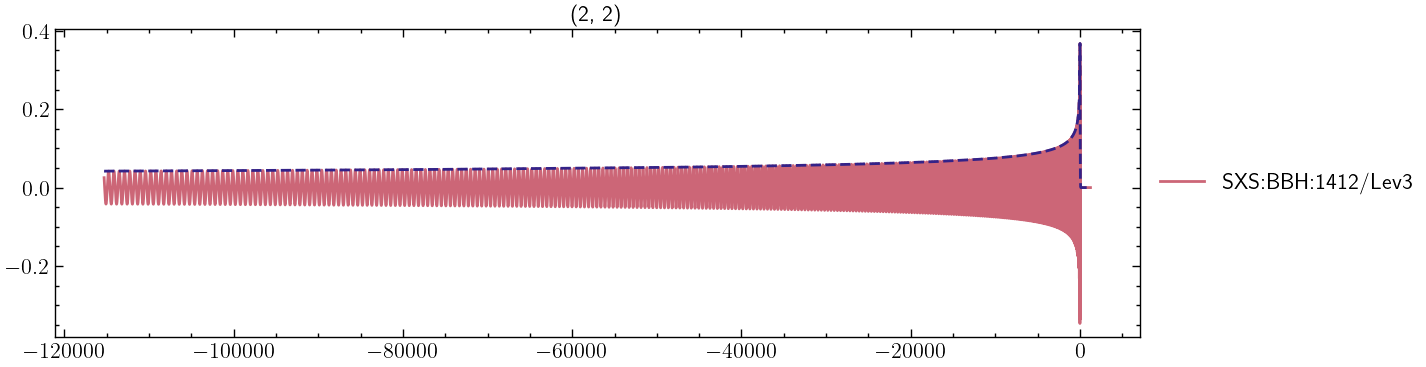

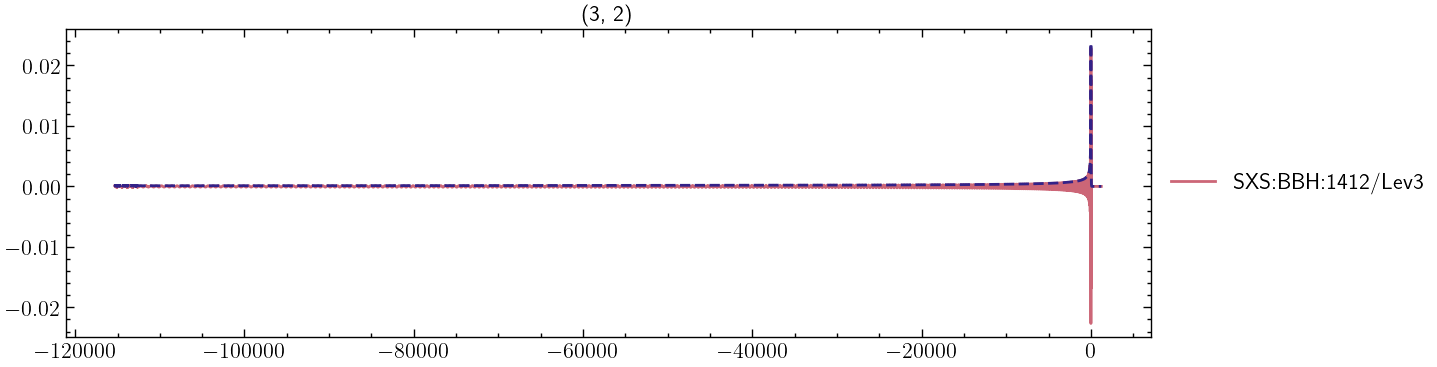

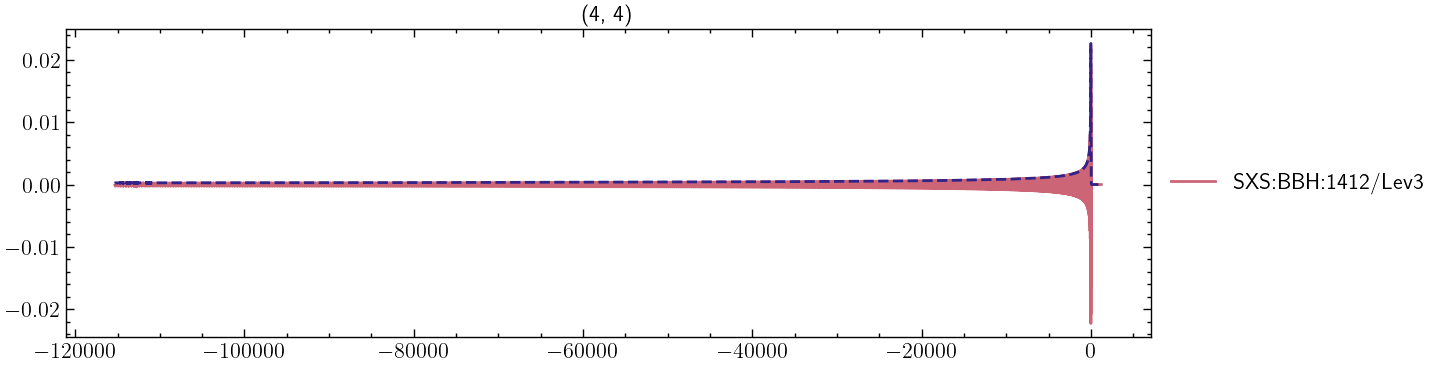

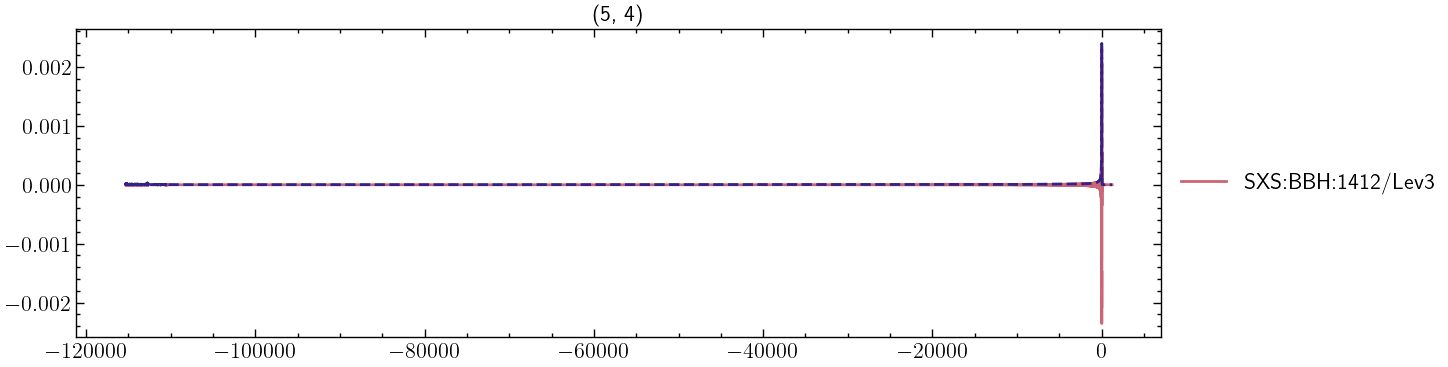

In [58]:
for mode in modes:
    plt.figure(figsize=(14, 4))
    plt.plot(wf_nr.times, wf_nr.hlms[mode].real, label=reference_sim)
    plt.plot(wf_nr.times, wf_nr.amplitudes[mode].real, ls='--')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=2)
    # plt.xlim(-100, 100)
    plt.title(mode)

# hybridise

We hybridise the same NR waveform with the same approximant at a fixed start frequency but varying the hybridisation windown to be later and later

In [59]:
# n_cycles_before_window_list = [0, 10, 30, 50, 65]
n_cycles_before_window_list = [0, 10, 20]

The plot below shows the different hybridisation windows

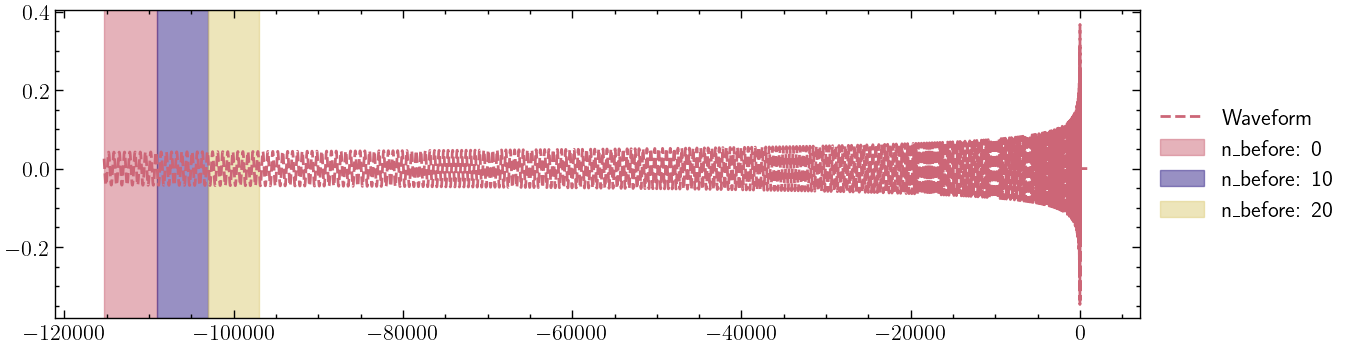

In [60]:
plt.figure(figsize=(14, 4))
plt.plot(wf_nr.times, wf_nr.hlms[2,2].real, ls='--', label='Waveform')
for i in range(len(n_cycles_before_window_list)):
    n_before = n_cycles_before_window_list[i]
    win1, win2 = prim.hybrid.get_window_times(wf_nr, n_cycles_before_window=n_before, n_cycles_in_window=10)

    plt.axvspan(win1, win2, color=f"C{i}", alpha=0.5, label=f"n_before: {n_cycles_before_window_list[i]}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## loop over approximants to build hybirds

In [61]:
%%time
M = 10

NR_start_frequency = phenom.MftoHz(np.abs(wf_nr.frequencies[2,2][0]), M) / 2 / np.pi
NR_start_frequency = np.around(NR_start_frequency, 2)

print(f"NR_start_frequency = {NR_start_frequency} Hz")


# f_min_left = NR_start_frequency - 40
f_min_left = 20

print(f"f_min_left = {f_min_left} Hz")

approximants = [
    "SEOBNRv5HM",
    "IMRPhenomTHM",
    "SEOBNRv4HM_PA",
    "NRHybSur3dq8",
    "SpinTaylorT4", 
    "SpinTaylorT1",
]
fit_modes = modes
n_cycles_before_window = 0
# n_cycles_in_window = 10
n_cycles_in_window = 50
n_tries=10
# deltaT = 1/4096*2
# deltaT = 1/4096
deltaT = 1/4096#/2/2

coarse_grid_params = {'on':True, 't0':-100, 't1':100, 'N':5000}

win1, win2 = prim.hybrid.get_window_times(wf_nr, n_cycles_before_window=n_cycles_before_window, n_cycles_in_window=n_cycles_in_window)

wf_hybrids = {}
hybrids_metadatas = {}
for approximant in approximants:
    tag = f"{approximant}"
    print(f"{tag = }")
    wf_left = utils.get_left_waveform_from_metadata(metadata[reference_sim], M, f_min_left, fit_modes, approximant, deltaT)
    print("fitting hybrid")
    wf_, hybrids_metadatas[tag] = utils.hybridise(
        wf_left, wf_nr, fit_modes=fit_modes,
        n_cycles_before_window=n_cycles_before_window, n_cycles_in_window=n_cycles_in_window,
        time_shift_guess=0, n_tries=n_tries, return_metadata=True,
        coarse_grid_params = coarse_grid_params
    )

    # time shift peak
    # only really need to do this for the reference hybrid
    t0_wf_, _ = (
        wf_.compute_amplitude().compute_phase().compute_frequency().compute_time_of_peak()
    )
    wf_.apply_time_shift(-t0_wf_)
    wf_.compute_amplitude().compute_phase().compute_frequency()
    wf_hybrids[tag] = copy.deepcopy(wf_)
    

print('done')

NR_start_frequency = 31.37 Hz
f_min_left = 20 Hz
tag = 'SEOBNRv5HM'
fitting hybrid
tag = 'IMRPhenomTHM'
fitting hybrid
tag = 'NRHybSur3dq8'
fitting hybrid
done
CPU times: user 15.3 s, sys: 356 ms, total: 15.7 s
Wall time: 15.5 s


In [62]:
for k in wf_hybrids:
    print(k, wf_hybrids[k].compute_time_of_peak())

SEOBNRv5HM (0.0, 336915)
IMRPhenomTHM (0.0, 336957)
NRHybSur3dq8 (0.0, 336924)


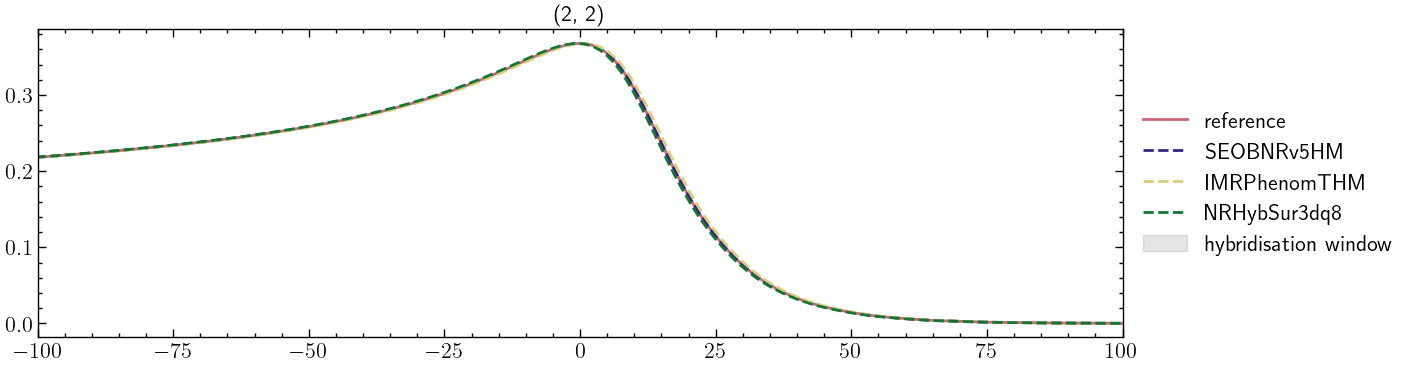

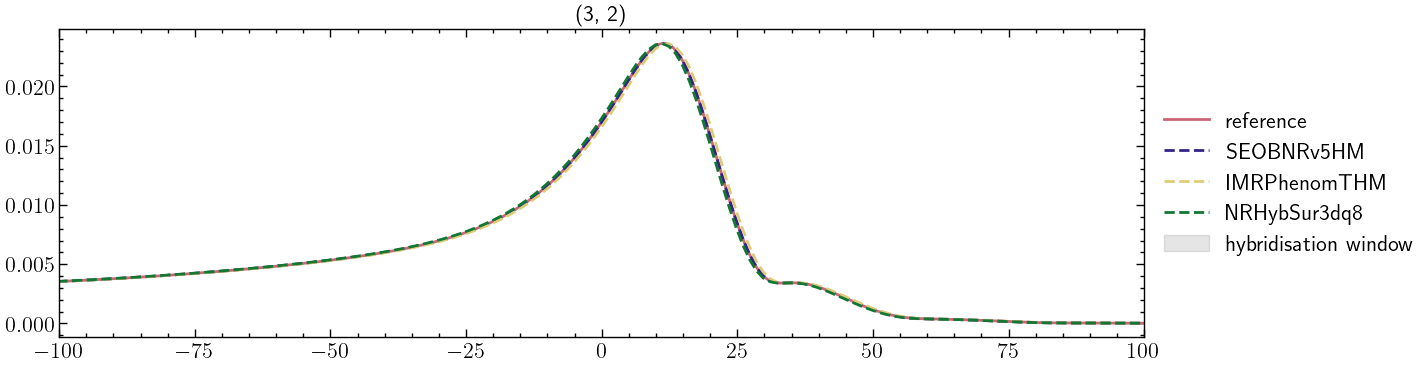

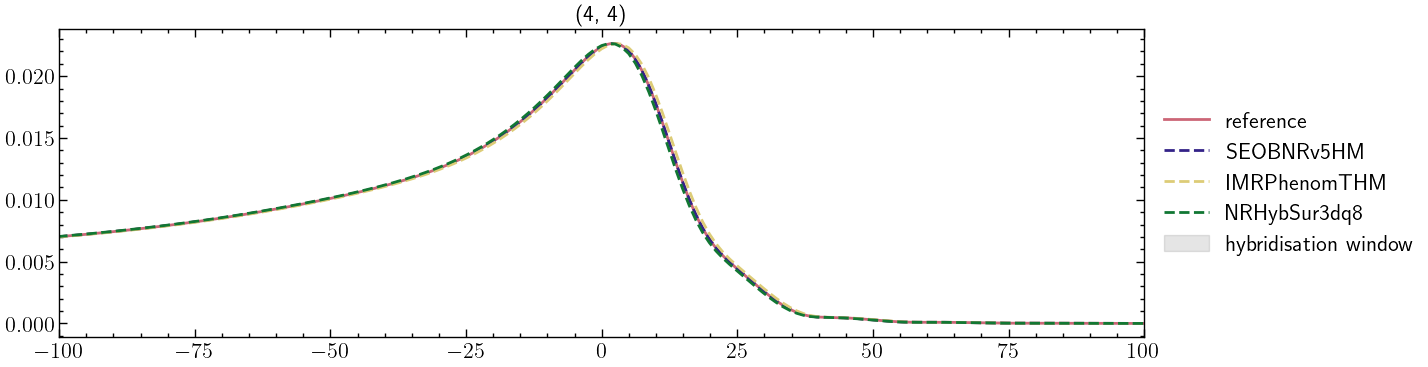

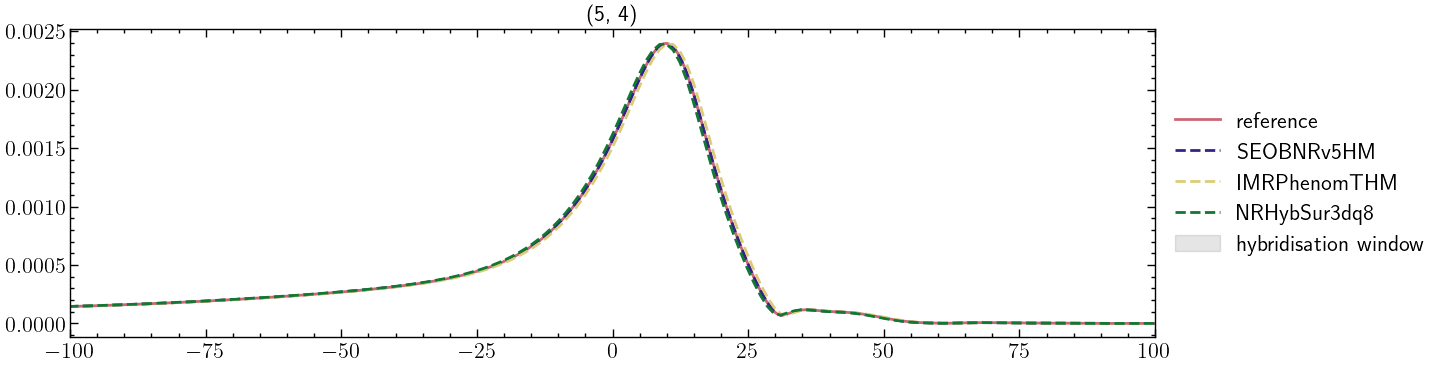

In [63]:
for mode in modes:
    plt.figure(figsize=(14, 4))
    # plt.figure()
    plt.plot(wf_nr.times, wf_nr.amplitudes[mode].real, label='reference')
    for k in wf_hybrids.keys():
        plt.plot(wf_hybrids[k].times, wf_hybrids[k].amplitudes[mode].real, ls='--', label=k)
    plt.xlim(-100, 100)
    # plt.xlim(-1000, 100)
    # plt.xlim(-5000, 100)
    plt.axvspan(win1, win2, color="k", alpha=0.1, label="hybridisation window")
    plt.title(mode)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.close()

## pick a reference hybrid and align at early times

In [64]:
reference_hybrid = list(wf_hybrids.keys())[0]
reference_hybrid

'SEOBNRv5HM'

In [65]:
other_hybrids = list(set(list(wf_hybrids.keys())) - set([reference_hybrid]))
other_hybrids = sorted(other_hybrids)
other_hybrids

['IMRPhenomTHM', 'NRHybSur3dq8']

Let's rotate the reference hybrid so that the orbital phase is zero at the start

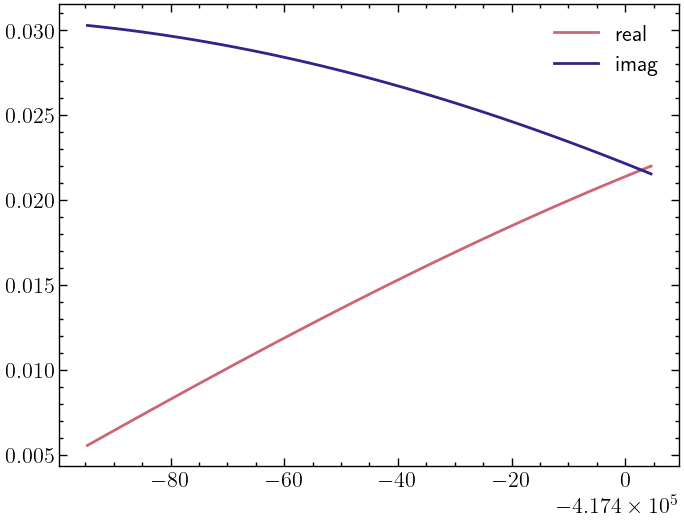

In [66]:
t_start = wf_hybrids[reference_hybrid].times[0]
mask = (wf_hybrids[reference_hybrid].times > t_start-100) & (wf_hybrids[reference_hybrid].times < t_start+100)

plt.figure()
plt.plot(wf_hybrids[reference_hybrid].times[mask], wf_hybrids[reference_hybrid].hlms[2,2].real[mask], label='real')
plt.plot(wf_hybrids[reference_hybrid].times[mask], wf_hybrids[reference_hybrid].hlms[2,2].imag[mask], label='imag')
plt.legend()

In [67]:
# divide by 2 to get orbital phase
phi0_ = np.angle(wf_hybrids[reference_hybrid].hlms[2,2])[0]/2
phi0_

0.6947837887677736

In [68]:
wf_hybrids[reference_hybrid].apply_phase_shift(-phi0_)

In [69]:
np.angle(wf_hybrids[reference_hybrid].hlms[2,2])[0]

8.686383526181769e-17

<Figure size 800x600 with 0 Axes>

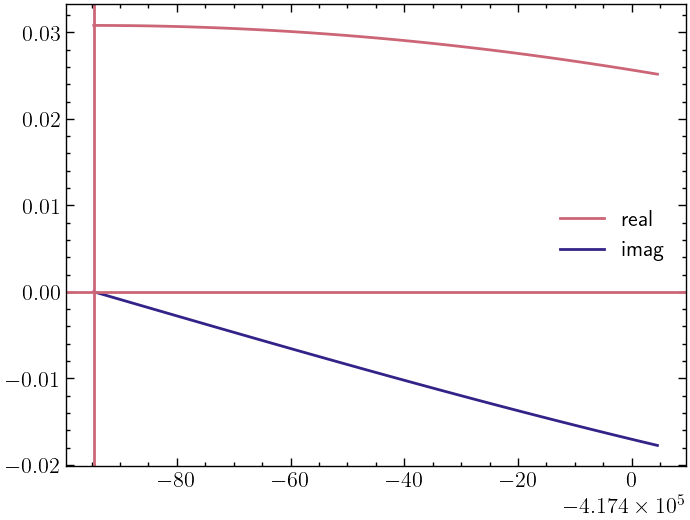

In [100]:
plt.figure()
plt.figure()
plt.plot(wf_hybrids[reference_hybrid].times[mask], wf_hybrids[reference_hybrid].hlms[2,2].real[mask], label='real')
plt.plot(wf_hybrids[reference_hybrid].times[mask], wf_hybrids[reference_hybrid].hlms[2,2].imag[mask], label='imag')
plt.axvline(wf_hybrids[reference_hybrid].times[0])
plt.axhline(0)
plt.legend()

In [71]:
%%time
wf_hybrids_aligned = {}
# don't use all of the right waveform to make the alignement code faster
# wf_right = copy.deepcopy(wf_hybrids[reference_hybrid]).mask(win1, win2)
wf_right = copy.deepcopy(wf_hybrids[reference_hybrid])
wf_hybrids_aligned[reference_hybrid] = copy.deepcopy(wf_hybrids[reference_hybrid])


coarse_grid_params = {'on':True, 't0':-100, 't1':100, 'N':1000}

n_cycles_before_window=0
n_cycles_in_window=200
win1, win2 = prim.hybrid.get_window_times(
    wf_right,
    n_cycles_before_window=n_cycles_before_window,
    n_cycles_in_window=n_cycles_in_window
)
print(win1, win2)

# for k in wf_hybrids.keys():
for k in other_hybrids:
    print(k)
    wf_hybrids_aligned[k] = utils.align_waveforms(
        wf_hybrids[k],
        wf_right,
        fit_modes,
        n_cycles_before_window=n_cycles_before_window,
        n_cycles_in_window=n_cycles_in_window,
        time_shift_guess=0,
        n_tries=10,
        coarse_grid_params = coarse_grid_params
    )

-417494.6124396863 -233792.76979173732
IMRPhenomTHM
NRHybSur3dq8
CPU times: user 2.79 s, sys: 186 ms, total: 2.98 s
Wall time: 2.69 s


In [72]:
for k in wf_hybrids_aligned:
    print(k, wf_hybrids_aligned[k].compute_time_of_peak())

SEOBNRv5HM (0.0, 336915)
IMRPhenomTHM (6.27846201026058, 336957)
NRHybSur3dq8 (2.6313924642484796, 336924)


In [73]:
dt = (wf_hybrids_aligned[reference_hybrid].times[1] - wf_hybrids_aligned[reference_hybrid].times[0])
dt

1.2391689667711034

In [74]:
common_start, common_end = utils.compute_common_time_bounds(wf_hybrids_aligned, use_max_end_times=True)
common_start, common_end

(-417494.6124396863, 1241.7299218810508)

In [75]:
new_times = np.arange(common_start, common_end, dt)

In [76]:
wf_hybrids_aligned[k].times.shape

(337921,)

In [77]:
for k in wf_hybrids_aligned.keys():
    print(k)
    wf_hybrids_aligned[k] = utils.interpolate_wf_onto_same_time_grid(wf_hybrids_aligned[k], new_times=new_times)

SEOBNRv5HM
IMRPhenomTHM
NRHybSur3dq8


In [78]:
for k in wf_hybrids_aligned:
    print(k, wf_hybrids_aligned[k].compute_time_of_peak())

SEOBNRv5HM (0.0, 336915)
IMRPhenomTHM (7.435013800626621, 336921)
NRHybSur3dq8 (2.478337933542207, 336917)


In [79]:
hyb_win1, hyb_win2 = hybrids_metadatas[reference_hybrid]['win1'],hybrids_metadatas[reference_hybrid]['win2']
hyb_win1, hyb_win2

(-115306.72984645779, -85541.31574900792)

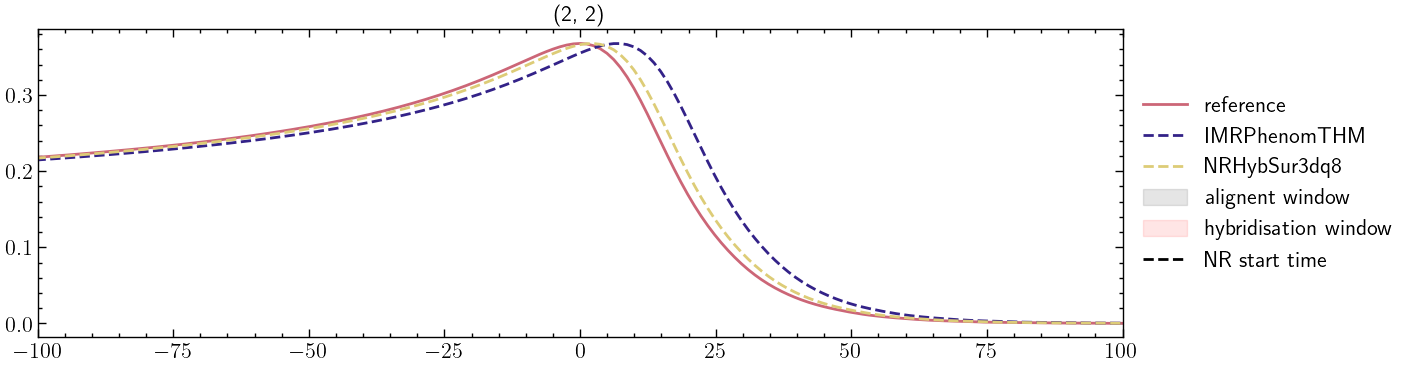

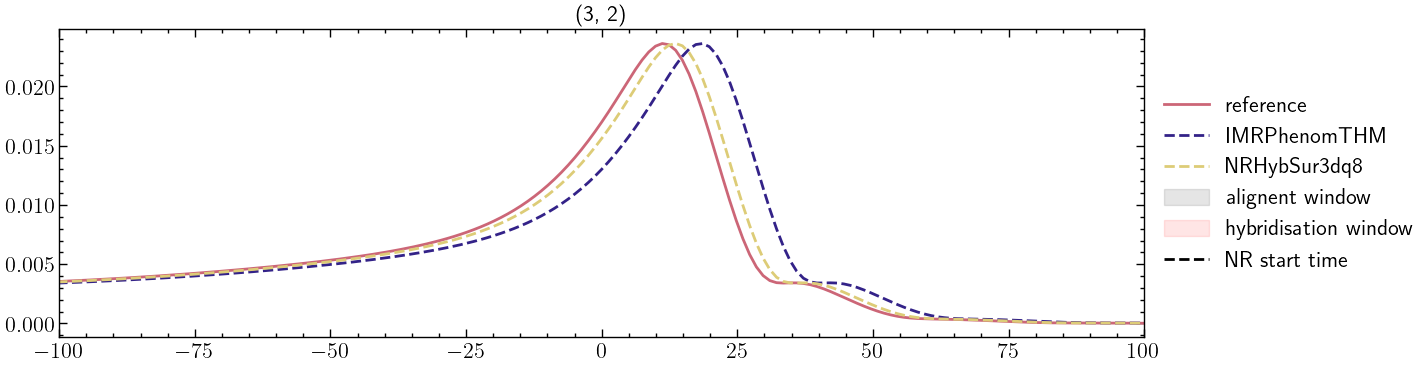

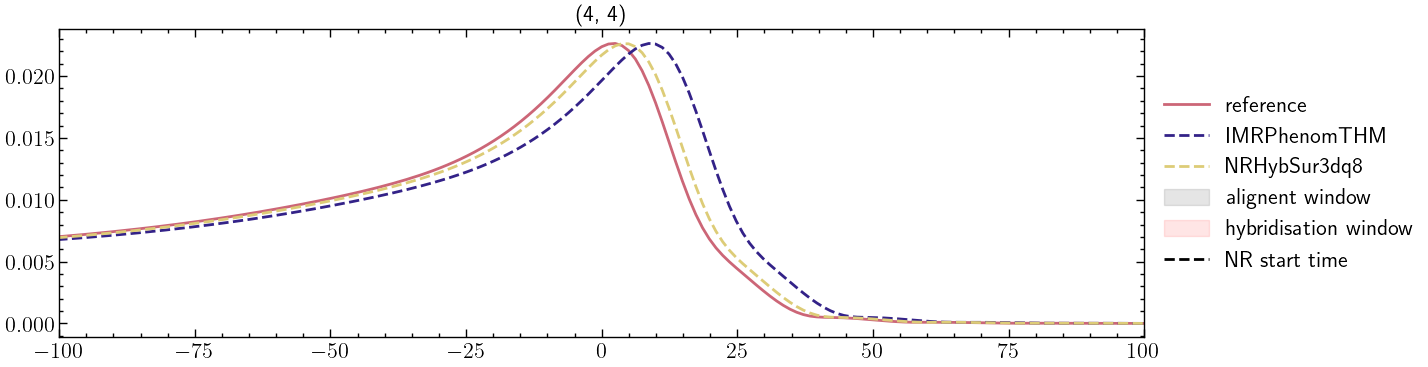

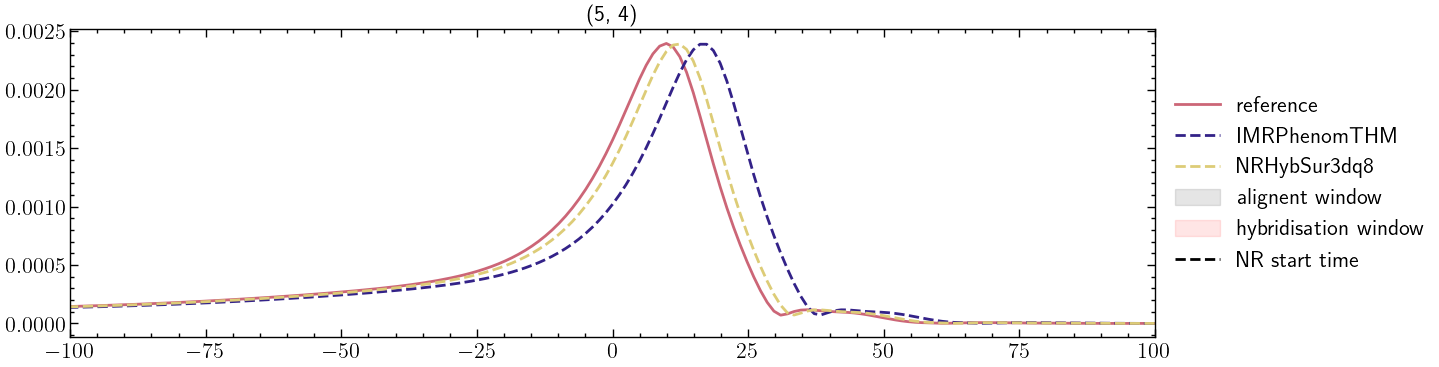

In [80]:
for mode in modes:
    plt.figure(figsize=(14, 4))
    # plt.figure()
    plt.plot(wf_hybrids_aligned[reference_hybrid].times, wf_hybrids_aligned[reference_hybrid].amplitudes[mode].real, label='reference')
    for k in other_hybrids:
        plt.plot(wf_hybrids_aligned[k].times, wf_hybrids_aligned[k].amplitudes[mode].real, ls='--', label=k)
    plt.xlim(-100, 100)
    # plt.xlim(-1000, 100)
    # plt.xlim(-5000, 100)
    plt.axvspan(win1, win2, color="k", alpha=0.1, label="alignent window")
    plt.axvspan(hyb_win1, hyb_win2, color="r", alpha=0.1, label="hybridisation window")
    plt.axvline(wf_nr.times[0], color='k', ls='--', label='NR start time')
    plt.title(mode)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.close()

IMRPhenomTHM
0.10753942983641812
NRHybSur3dq8
0.0820592001269955


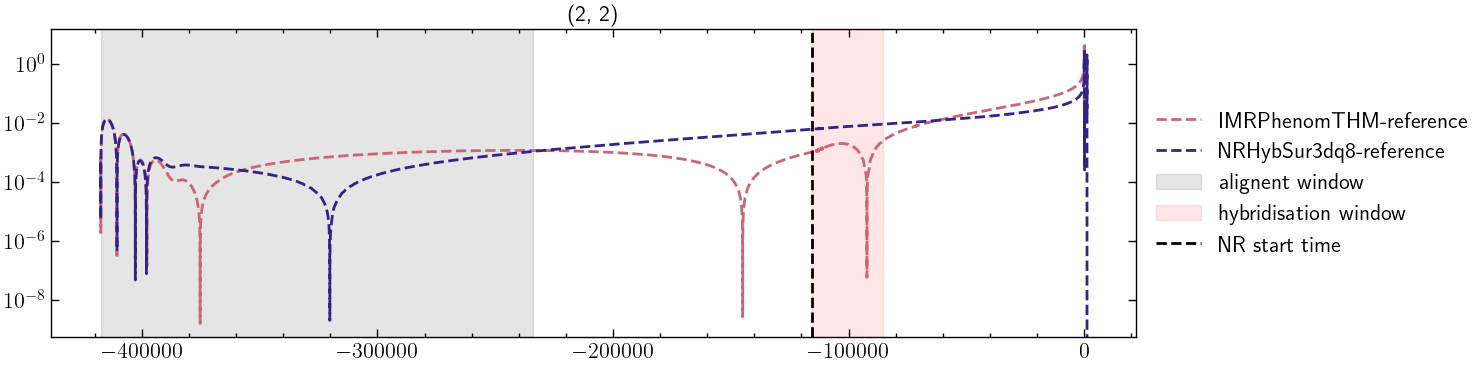

IMRPhenomTHM
0.10921755851177015
NRHybSur3dq8
0.08310006940725306


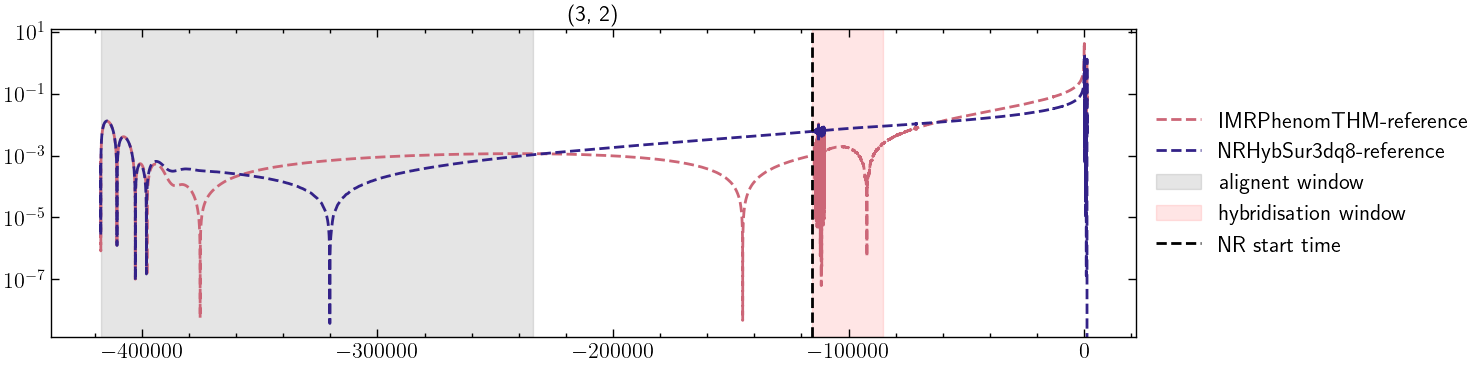

IMRPhenomTHM
0.15246485705287624
NRHybSur3dq8
0.11624183165903058


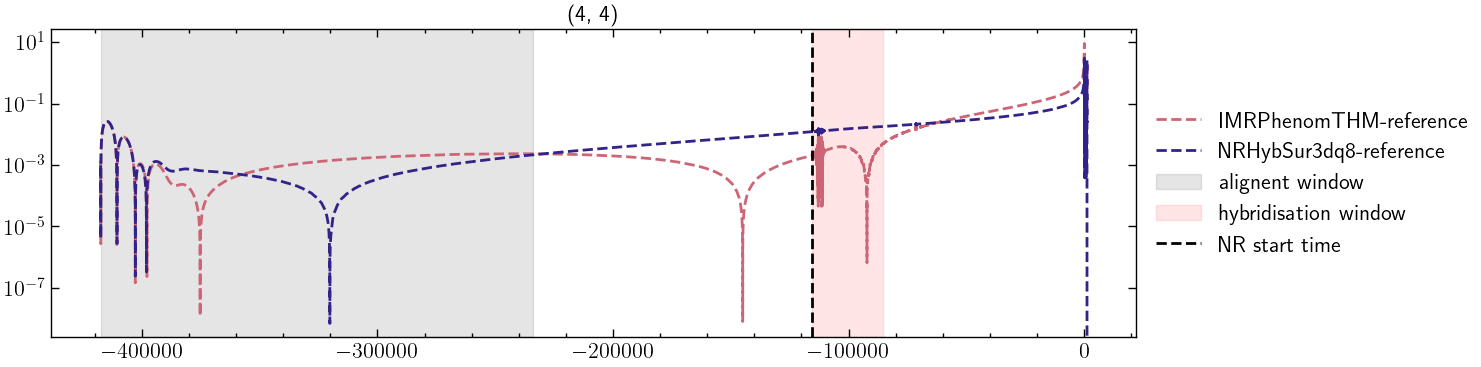

IMRPhenomTHM
0.1521492285164526
NRHybSur3dq8
0.11606428105582148


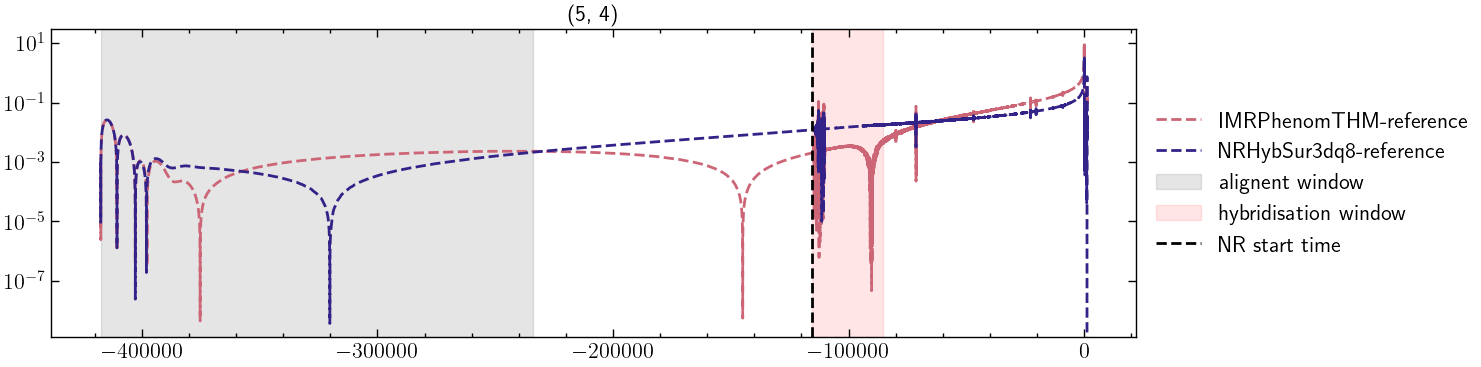

In [81]:
for mode in modes:
    plt.figure(figsize=(14, 4))
    # plt.figure()
    x = wf_hybrids_aligned[reference_hybrid].times
    y1 = wf_hybrids_aligned[reference_hybrid].phases[mode].real
    for k in other_hybrids:
        print(k)
        y2 = wf_hybrids_aligned[k].phases[mode].real
        delta_y = y1-y2
        delta_y = np.abs(delta_y)
        print(np.sqrt(delta_y.mean()))
        plt.plot(x, delta_y, ls='--', label=f"{k}-reference")
    # plt.xlim(-100, 100)
    # plt.xlim(-1000, 100)
    # plt.xlim(-5000, 100)
    # plt.ylim(1e-6, 0.2)
    # plt.ylim(0,10)
    plt.yscale('log')
    plt.axvspan(win1, win2, color="k", alpha=0.1, label="alignent window")
    plt.axvspan(hyb_win1, hyb_win2, color="r", alpha=0.1, label="hybridisation window")
    plt.title(mode)

    plt.axvline(wf_nr.times[0], color='k', ls='--', label='NR start time')
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.close()